In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [10]:
df = pd.read_csv("churn_data.csv")
print(df.head(5))
print(df.shape)

   customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity  ... DeviceProtection  \
0  No phone service             DSL             No  ...               No   
1                No             DSL            Yes  ...              Yes   
2                No             DSL            Yes  ...               No   
3  No phone service             DSL            Yes  ...              Yes   
4                No     Fiber optic             No  ...               No   

  TechSupport StreamingTV StreamingMovies        Contract Pape

In [11]:
missing = df.isna().sum()
print(missing)

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64


In [12]:
df.drop(columns=['customerID'], inplace=True) #CustomerID is not useful for Prediction

In [14]:
#Convert TotalCharges to Numeric
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df['TotalCharges'].fillna(df['TotalCharges'].median())

0         29.85
1       1889.50
2        108.15
3       1840.75
4        151.65
         ...   
7038    1990.50
7039    7362.90
7040     346.45
7041     306.60
7042    6844.50
Name: TotalCharges, Length: 7043, dtype: float64

In [15]:
#Encoding the Target Variable
df['Churn'] = df['Churn'].map({'Yes': 1, 'No': 0})

In [16]:
categorical_cols = df.select_dtypes(include=['object']).columns

le = LabelEncoder()
for col in categorical_cols:
    df[col] = le.fit_transform(df[col])

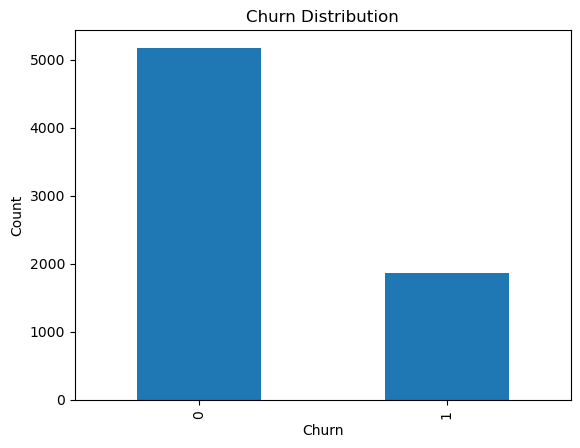

In [17]:
plt.figure()
df['Churn'].value_counts().plot(kind='bar')
plt.title("Churn Distribution")
plt.xlabel("Churn")
plt.ylabel("Count")
plt.show()

<Figure size 640x480 with 0 Axes>

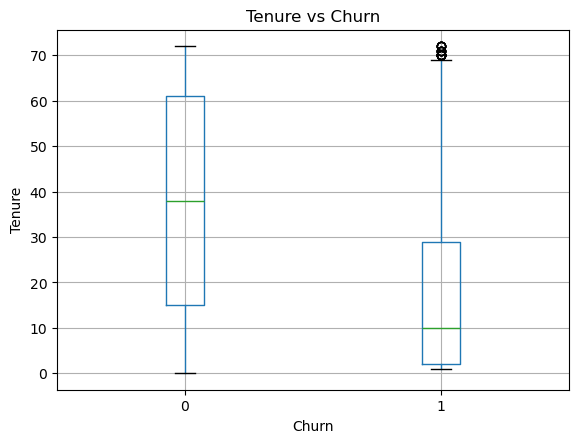

In [18]:
plt.figure()
df.boxplot(column='tenure', by='Churn')
plt.title("Tenure vs Churn")
plt.suptitle("")
plt.xlabel("Churn")
plt.ylabel("Tenure")
plt.show()

<Figure size 640x480 with 0 Axes>

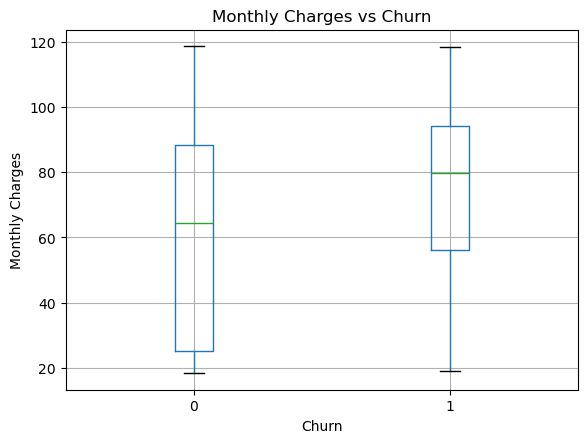

In [19]:
plt.figure()
df.boxplot(column='MonthlyCharges', by='Churn')
plt.title("Monthly Charges vs Churn")
plt.suptitle("")
plt.xlabel("Churn")
plt.ylabel("Monthly Charges")
plt.show()

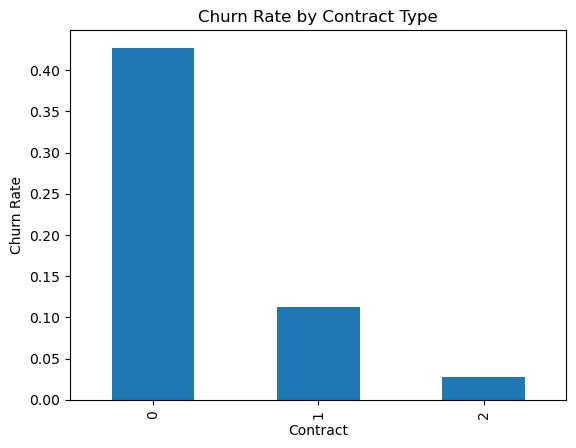

In [21]:
plt.figure()
df.groupby('Contract')['Churn'].mean().plot(kind='bar')
plt.title("Churn Rate by Contract Type")
plt.xlabel("Contract")
plt.ylabel("Churn Rate")
plt.show()

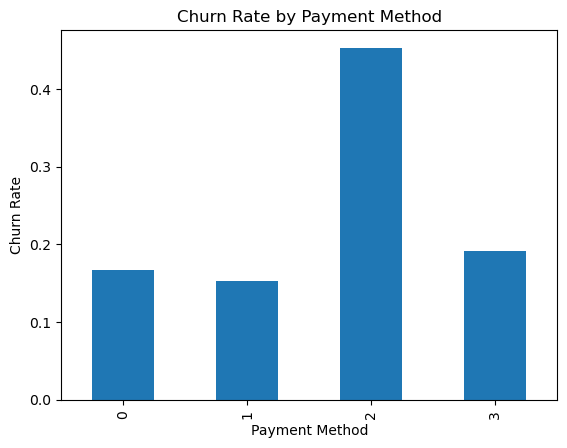

In [22]:
plt.figure()
df.groupby('PaymentMethod')['Churn'].mean().plot(kind='bar')
plt.title("Churn Rate by Payment Method")
plt.xlabel("Payment Method")
plt.ylabel("Churn Rate")
plt.show()

In [23]:
X = df.drop('Churn', axis=1)
y = df['Churn']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [24]:
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

In [29]:
rf = RandomForestClassifier(
    n_estimators=200,
    random_state=42,
    class_weight='balanced'
)

rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)

print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))

Random Forest Accuracy: 0.7835344215755855
              precision    recall  f1-score   support

           0       0.82      0.90      0.86      1035
           1       0.62      0.47      0.54       374

    accuracy                           0.78      1409
   macro avg       0.72      0.68      0.70      1409
weighted avg       0.77      0.78      0.77      1409



In [26]:
lgbm = LGBMClassifier(
    n_estimators=300,
    learning_rate=0.05,
    class_weight='balanced',
    random_state=42
)

lgbm.fit(X_train, y_train)

y_pred_lgbm = lgbm.predict(X_test)

print("LightGBM Accuracy:", accuracy_score(y_test, y_pred_lgbm))
print(classification_report(y_test, y_pred_lgbm))

[LightGBM] [Info] Number of positive: 1495, number of negative: 4139
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000761 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 643
[LightGBM] [Info] Number of data points in the train set: 5634, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
LightGBM Accuracy: 0.7636621717530163
              precision    recall  f1-score   support

           0       0.89      0.78      0.83      1035
           1       0.54      0.73      0.62       374

    accuracy                           0.76      1409
   macro avg       0.71      0.75      0.72      1409
weighted avg       0.80      0.76      0.77      1409



/opt/anaconda3/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


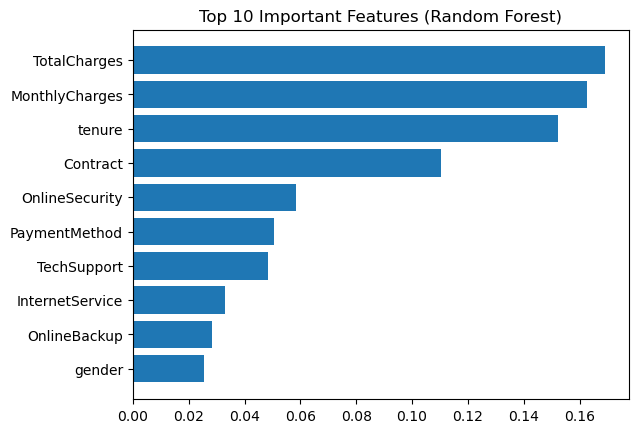

In [27]:
importances = rf.feature_importances_
features = X.columns

feature_df = pd.DataFrame({
    'Feature': features,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

plt.figure()
plt.barh(feature_df['Feature'][:10], feature_df['Importance'][:10])
plt.title("Top 10 Important Features (Random Forest)")
plt.gca().invert_yaxis()
plt.show()
